### 0. Imports

In [2]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'matplotlib.backends.registry'

In [1]:

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_outliers as so
import src.ab_testing_support as ats
import src.association_metrics as am
import src.data_preparation as dp
import src.model_evaluation_support as mes
import src.soporte_ajuste_logistica_miercoles as salm

# Machine Learning tools
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import  RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV

import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline



# encoding
# -----------------------------------------------------------------------
from sklearn.preprocessing import  OneHotEncoder
import category_encoders as ce
# set category encoder compatibility
import sklearn
sklearn.set_config(transform_output="pandas")

# scaling
# -----------------------------------------------------------------------
from sklearn.preprocessing import  RobustScaler, StandardScaler


# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr

# model tracking
# -----------------------------------------------------------------------
import mlflow

# definir semilla random
# -----------------------------------------------------------------------
seed = 42


ModuleNotFoundError: No module named 'matplotlib.backends.registry'

# 1. Introduction - Employee Retention - Model Evaluation

## 1.1 Data import

In [368]:
employee_attrition = pd.read_pickle("../data/explored/employee_attrition_explored.pkl")
employee_attrition.duplicated(keep=False).sum()

4306

## 2. Set experiment tracking with MLflow

Set MLFlow tracking folder, activate autolog and set an experiment name for tracking.

In [70]:
# mlflow.set_tracking_uri("../model_tracking")  # Local directory
# mlflow.set_experiment("employee_retention")
# mlflow.autolog()

# 3. Model evaluation

## 3.1 Experiment 1 - baseline

### 3.1.1 Data preparation

Data preparation for load, cleaning and correction of errors found throughout the 1_exploration_cleaning, 2_EDA and 3_preprocessing notebooks have been integrated into a load and clean function, available at ``src/data_preparation.py``.

In [497]:
list_of_paths = ["../data/general_data.csv","../data/employee_survey_data.csv","../data/manager_survey_data.csv"]

employee_attrition = dp.load_and_clean(list_of_paths, "EmployeeID")
employee_attrition

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,gender,joblevel,jobrole,...,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,1.0,6,1.0,0,0,3.0,4.0,2.0,3,3
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,6.0,3,5.0,1,4,3.0,2.0,4.0,2,4
2,32,0,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,5.0,2,5.0,0,3,2.0,2.0,1.0,3,3
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,13.0,5,8.0,7,5,4.0,4.0,3.0,2,3
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,9.0,2,6.0,0,4,4.0,1.0,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,36,0,Travel_Rarely,Research & Development,2,3,Life Sciences,Male,2,Sales Representative,...,5.0,2,1.0,0,0,2.0,4.0,3.0,3,3
4305,45,0,Travel_Rarely,Sales,1,4,Technical Degree,Male,1,Research Scientist,...,20.0,3,17.0,0,10 or more,2.0,2.0,NaN,3,3
4332,31,0,Travel_Rarely,Sales,2,5,Life Sciences,Male,2,Sales Representative,...,7.0,3,4.0,0,2,NaN,4.0,3.0,4,3
4395,40,0,Travel_Rarely,Research & Development,2,3,Life Sciences,Male,1,Manufacturing Director,...,9.0,4,9.0,4,7,1.0,4.0,3.0,2,3


### 3.1.2 Define target and predictors

In [492]:
y = employee_attrition["attrition"]
X = employee_attrition.drop(columns="attrition")

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

### 3.1.3 Data preprocessing

- Missing: Median imputation for numerical features. Mode for categorical.
- Outliers: False.
- Encoding: One hot encoder for <= 3 categories. Target for others.
- Scaling: False. (Only tree based models will be used)

Setting the conditions for data preprocessing:

In [493]:
categorical = X.select_dtypes("object").columns.to_list()

# current numpy version doesn't work well with np.number for this:
numerical = X.select_dtypes(["int64","float64"]).columns.to_list()

all_columns = X.columns.to_list()

columns_one_hot = [col for col in categorical if X[col].nunique() <= 3]
columns_target =[col for col in categorical if X[col].nunique() > 3]


imputer = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

# Combine into a pipeline to later append the model
preprocessing_pipeline_target = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

Checking the preprocessing pipeline:

In [ ]:
preprocessing_pipeline_target.fit_transform(X,y).sample(7)

,age,distancefromhome,monthlyincome,totalworkingyears,yearsatcompany,businesstravel_Travel_Rarely,businesstravel_Travel_Frequently,businesstravel_Non-Travel,department_Sales,department_Research & Development,...,percentsalaryhike,trainingtimeslastyear,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating_3.0,performancerating_4.0
118,51.0,1.0,41050.0,18.0,7.0,1,0,0,0,1,...,0.175071,0.174873,0.192,0.133047,0.140594,0.110236,0.170868,0.154341,0,1
1256,30.0,1.0,20330.0,12.0,12.0,0,1,0,0,1,...,0.136364,0.172414,0.16947,0.133047,0.140594,0.110236,0.139202,0.211065,1,0
3085,41.0,7.0,27820.0,10.0,10.0,1,0,0,0,1,...,0.136364,0.174873,0.192,0.133047,0.148026,0.110236,0.139202,0.156962,1,0
690,30.0,6.0,30410.0,9.0,9.0,1,0,0,0,1,...,0.134529,0.174873,0.192,0.094832,0.148026,0.229236,0.139202,0.156962,1,0
717,55.0,19.0,46800.0,24.0,19.0,1,0,0,0,1,...,0.136364,0.181185,0.16947,0.094832,0.247492,0.166667,0.170868,0.174194,1,0
1083,31.0,2.0,103770.0,10.0,10.0,1,0,0,0,1,...,0.136364,0.174873,0.192,0.145604,0.148026,0.166667,0.139202,0.154341,1,0
1075,46.0,4.0,27430.0,14.0,8.0,1,0,0,0,1,...,0.180444,0.146722,0.192,0.133047,0.140594,0.165541,0.139202,0.174194,0,1


### 3.1.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [399]:
models = {
    'decision_tree': (
        DecisionTreeClassifier(random_state=seed),
        {
            'classifier__max_depth': [None, 5, 10, 15],
            'classifier__min_samples_split': [5, 10, 15],
            'classifier__min_samples_leaf': [2, 5, 10],
            'classifier__max_leaf_nodes': [20, 30, None],
            'classifier__max_features': ['sqrt', 'log2']
        }
    ),

    'random_forest': (
        RandomForestClassifier(random_state=seed, n_jobs=-1),
        {
            'classifier__n_estimators': [50, 100, 150, 200],
            'classifier__max_depth': [10, 15, 20, 25],
            'classifier__min_samples_split': [2, 5, 10, 15],
            'classifier__min_samples_leaf': [1, 5, 10],
            'classifier__bootstrap': [True, False]
        }
    ),

    'xgboost': (
        XGBClassifier(n_jobs=-1, random_state=seed),
        {
            'classifier__n_estimators': [50, 75],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3,5],
            'classifier__min_child_weight': [1, 2],
            'classifier__colsample_bytree': [0.8,0.9],
            'classifier__gamma': [0.05, 1, 1.5],
            'classifier__reg_alpha': [0.05, 0.1],
            'classifier__reg_lambda': [1],
        }
    )

# {'classifier__colsample_bytree': 0.85,
#  'classifier__gamma': 1.5,
#  'classifier__learning_rate': 0.05,
#  'classifier__max_depth': 3,
#  'classifier__min_child_weight': 3,
#  'classifier__n_estimators': 75,
#  'classifier__reg_alpha': 0.05,
#  'classifier__reg_lambda': 1}

}


### 3.1.5 Run experiment

Perform train and test split. Define a stratified kfold cross validation to improve metric robustness in face of target imbalance. Optimize for minimal average_precision_score, which is the equivalent of the area under the Precision-Recall curve, which is more informative than AUC for imbalanced datasets.

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
score = "average_precision"

verbosity = 2

Evaluate Decision Tree:

In [ ]:
analista_clasificacion = salm.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration1")

analista_clasificacion.ajustar_modelo("decision_tree", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["decision_tree"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion.calcular_metricas("decision_tree")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.860095,0.839528,0.860095,0.834299,0.316946,0.770798,0.459357,0.400463,0.081684,12.0
test,0.841270,0.808657,0.841270,0.814388,0.230957,0.572189,0.255678,0.400463,0.081684,12.0


Evaluate Random Forest:

In [ ]:
analista_clasificacion.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.938792,0.942952,0.938792,0.932662,0.731573,0.999119,0.995768,1.065875,0.225568,12.0
test,0.857143,0.846509,0.857143,0.812635,0.198473,0.765283,0.511263,1.065875,0.225568,12.0


Evaluate Xgboost:

In [ ]:
analista_clasificacion.ajustar_modelo("xgboost", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["xgboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion.calcular_metricas("xgboost")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.872019,0.875765,0.872019,0.838097,0.319589,0.883645,0.701172,0.335253,0.067971,12.0
test,0.857143,0.846509,0.857143,0.812635,0.198473,0.711170,0.406924,0.335253,0.067971,12.0


In [404]:
for model in models.keys():
    print(f"{model} - best params:")
    display(analista_clasificacion.resultados[model]["best_params"])

decision_tree - best params:


{'classifier__max_depth': 5,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 5}

random_forest - best params:


{'classifier__bootstrap': True,
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 200}

xgboost - best params:


{'classifier__colsample_bytree': 0.9,
 'classifier__gamma': 1.5,
 'classifier__learning_rate': 0.05,
 'classifier__max_depth': 3,
 'classifier__min_child_weight': 2,
 'classifier__n_estimators': 75,
 'classifier__reg_alpha': 0.05,
 'classifier__reg_lambda': 1}

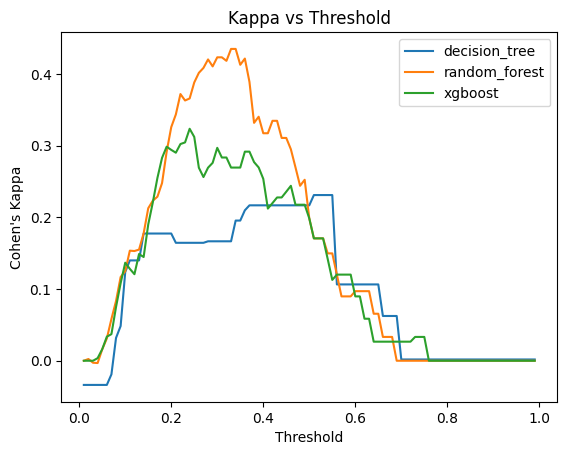

In [405]:
analista_clasificacion.plot_cohens_kappa(models.keys())

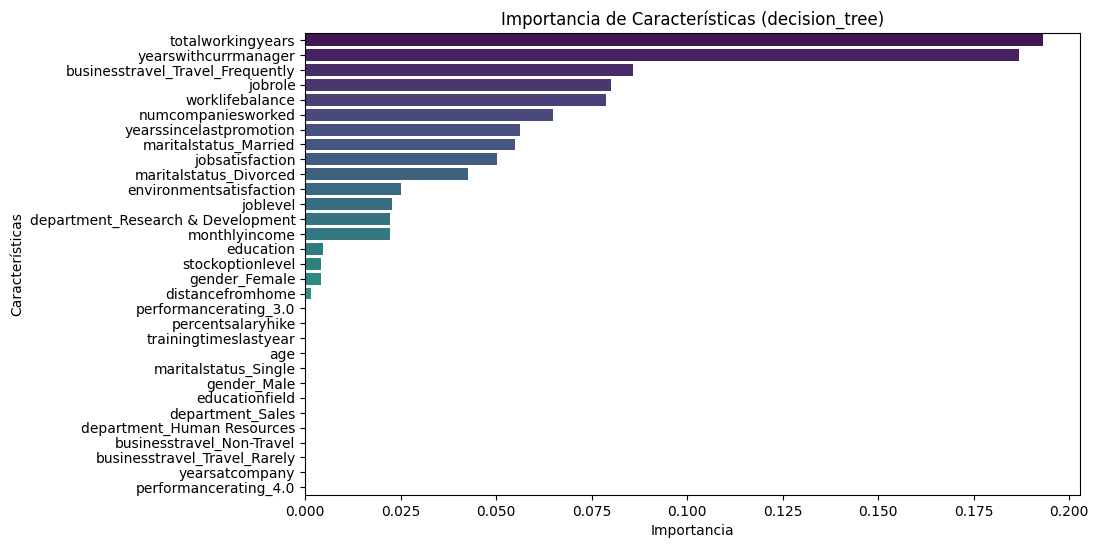

In [406]:
analista_clasificacion.importancia_predictores("decision_tree", pipeline=True)

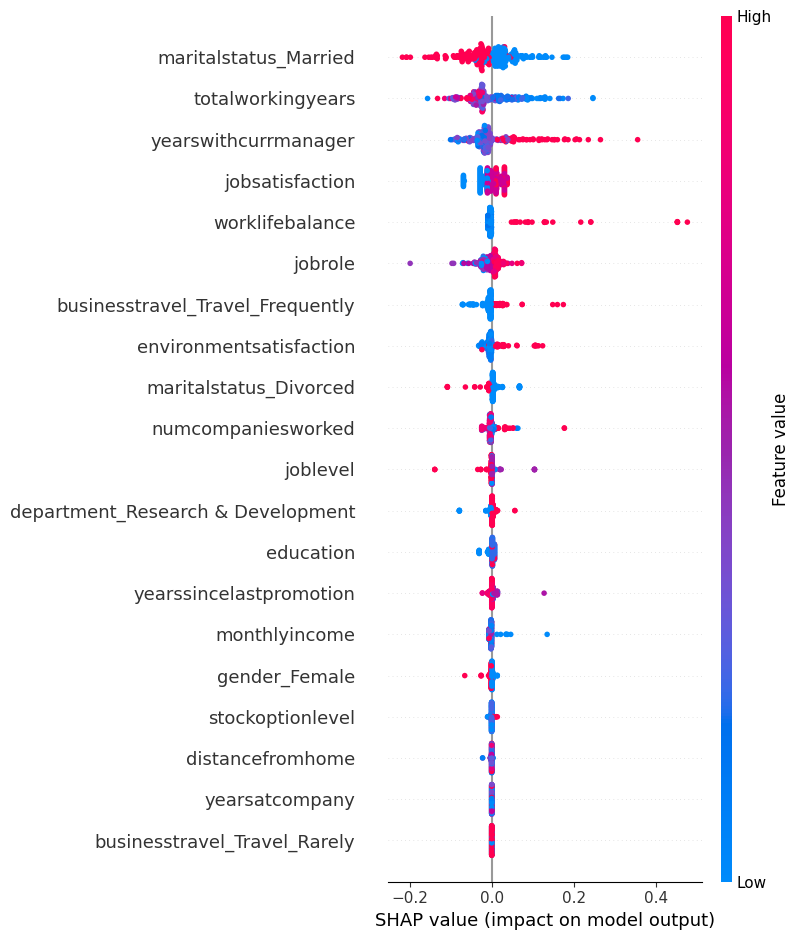

In [407]:
analista_clasificacion.plot_shap_summary("decision_tree", pipeline=True)

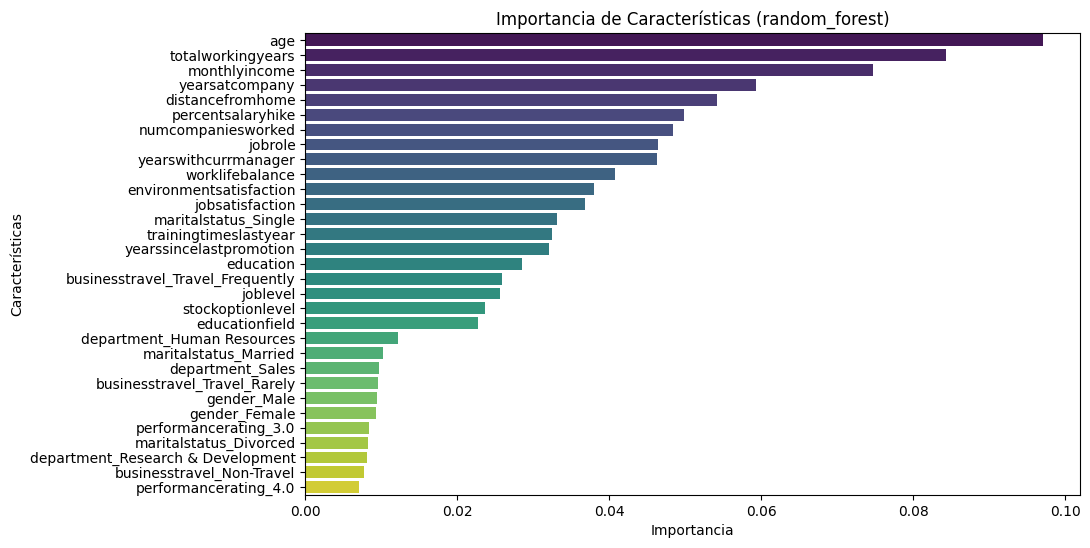

In [408]:
analista_clasificacion.importancia_predictores("random_forest", pipeline=True)

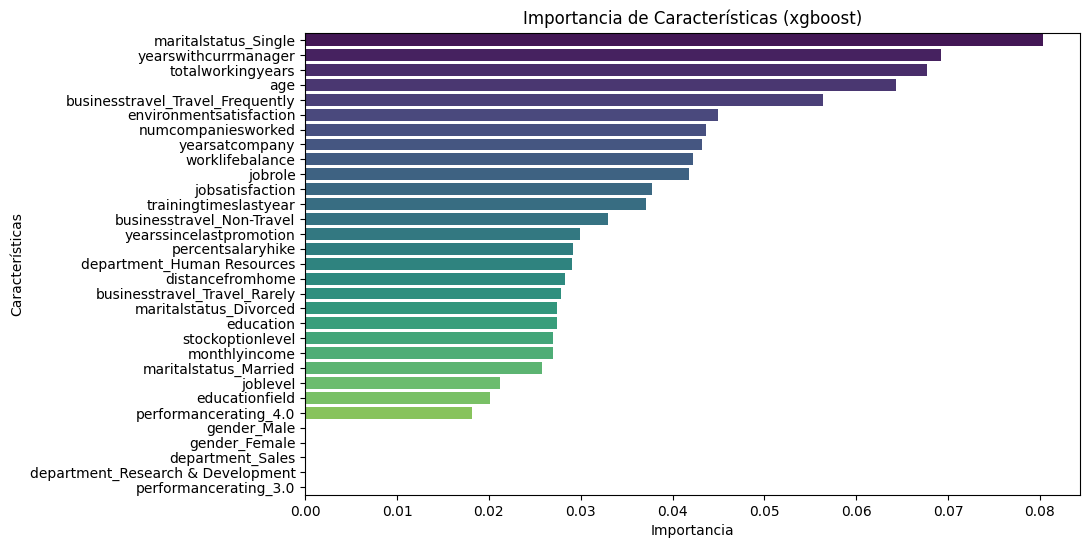

In [205]:
analista_clasificacion.importancia_predictores("xgboost", pipeline=True)

## 3.2 Experiment 2

Same, only changing the TargetEncoder for a CatBoost encoder.

In [208]:
analista_clasificacion_2 = salm.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration2")

In [ ]:
preprocessing_pipeline_catboost_encoder = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.CatBoostEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

In [ ]:
analista_clasificacion_2.ajustar_modelo("decision_tree", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["decision_tree"][1], 
                                        cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("decision_tree")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.826709,0.756654,0.826709,0.774879,0.048676,0.642828,0.251511,0.266306,0.08197,12.0
test,0.825397,0.761969,0.825397,0.779821,0.065786,0.596830,0.246539,0.266306,0.08197,12.0


In [ ]:
analista_clasificacion_2.ajustar_modelo("xgboost", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["xgboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("xgboost")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.862480,0.857269,0.862480,0.823532,0.256069,0.802034,0.539659,0.328108,0.108358,12.0
test,0.847619,0.815144,0.847619,0.802172,0.155307,0.691321,0.355468,0.328108,0.108358,12.0


In [ ]:
analista_clasificacion_2.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.863275,0.867504,0.863275,0.821487,0.244940,0.873631,0.631131,0.932788,0.225184,12.0
test,0.850794,0.831736,0.850794,0.800113,0.141988,0.728453,0.413202,0.932788,0.225184,12.0


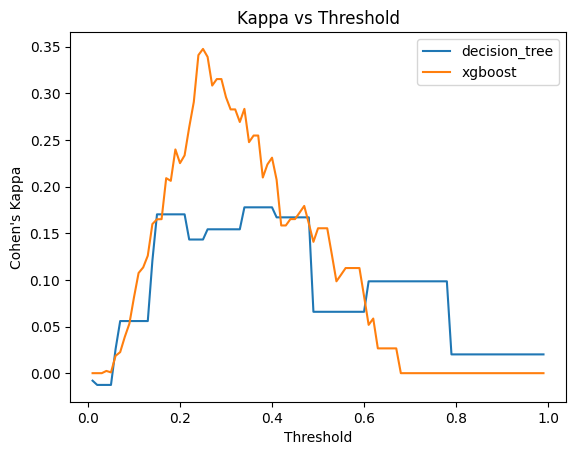

In [215]:
analista_clasificacion_2.plot_cohens_kappa(["decision_tree", "xgboost"])

## 3.3 Experiment 3

Catboost, not optimized. A small number of iterations will be tested as it is a quite intensive algorithm.

No encoding is needed.

In [424]:
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__iterations': [50,100,150]
        }
    )

preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer)
])

In [440]:
analista_clasificacion_3 = salm.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration3")

analista_clasificacion_3.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_3.calcular_metricas("catboost")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2613, in _catboost.get_cat_factor_bytes_representation
  File "_catboost.pyx", line 2128, in _catboost.get_id_object_bytes_string_representation
_catboost.CatBoostError: bad object for id: 4.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3100, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2620, in _catboost.get_cat_factor_bytes_representation
_catboost.CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=19]=4.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2613, in _catboost.get_cat_factor_bytes_representation
  File "_catboost.pyx", line 2128, in _catboost.get_id_object_bytes_string_representation
_catboost.CatBoostError: bad object for id: 3.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3100, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2620, in _catboost.get_cat_factor_bytes_representation
_catboost.CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=19]=3.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.


In [348]:
display(analista_clasificacion_3.resultados["catboost"]["mejor_modelo"]["classifier"].get_best_iteration())
analista_clasificacion_3.resultados["catboost"]["mejor_modelo"]["classifier"].get_params()

None

{'verbose': 100,
 'custom_metric': 'PRAUC',
 'eval_metric': 'PRAUC',
 'random_state': 42,
 'early_stopping_rounds': 50,
 'cat_features': ['businesstravel',
  'department',
  'education',
  'educationfield',
  'gender',
  'joblevel',
  'jobrole',
  'maritalstatus',
  'numcompaniesworked',
  'percentsalaryhike',
  'stockoptionlevel',
  'trainingtimeslastyear',
  'yearssincelastpromotion',
  'yearswithcurrmanager',
  'environmentsatisfaction',
  'jobsatisfaction',
  'worklifebalance',
  'jobinvolvement',
  'performancerating'],
 'iterations': 150}

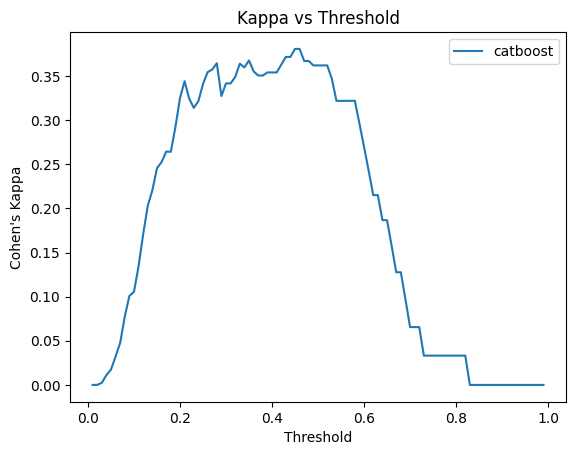

In [ ]:
analista_clasificacion_3.plot_cohens_kappa(["catboost"])

## 3.4 Experiment 4

Catboost, optimized. 



In [451]:
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__depth': [6,8,10],
            'classifier__l2_leaf_reg': [1, 3, 5],
            'classifier__border_count': [32, 64],
            'classifier__bagging_temperature': [0.5, 1],
            'classifier__iterations': [50,100,150]
        }
    )

imputer_catboost = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy="constant", fill_value="NaN"), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer_catboost)
])

In [ ]:
analista_clasificacion_4 = salm.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration4")

analista_clasificacion_4.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_4.calcular_metricas("catboost")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0:	learn: 0.2534726	total: 26.9ms	remaining: 4.01s
100:	learn: 0.5497164	total: 3.6s	remaining: 1.75s
149:	learn: 0.6034888	total: 5.36s	remaining: 0us


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.858506,0.873225,0.858506,0.809336,0.189621,0.829963,0.581113,8.535744,0.021078,12.0
test,0.860317,0.880208,0.860317,0.810796,0.186620,0.742415,0.489985,8.535744,0.021078,12.0


Somehow, Catboost works best when no other hyperparameters other than the iterations number is modified. Or at the very least, there is one parameter that should not be modified (learning rate is for sure one of them) and throws off the whole optimization.

In [349]:
display(analista_clasificacion_4.resultados["catboost"]["mejor_modelo"]["classifier"].get_best_iteration())
analista_clasificacion_4.resultados["catboost"]["mejor_modelo"]["classifier"].get_params()

None

{'verbose': 100,
 'custom_metric': 'PRAUC',
 'eval_metric': 'PRAUC',
 'random_state': 42,
 'early_stopping_rounds': 50,
 'cat_features': ['businesstravel',
  'department',
  'education',
  'educationfield',
  'gender',
  'joblevel',
  'jobrole',
  'maritalstatus',
  'numcompaniesworked',
  'percentsalaryhike',
  'stockoptionlevel',
  'trainingtimeslastyear',
  'yearssincelastpromotion',
  'yearswithcurrmanager',
  'environmentsatisfaction',
  'jobsatisfaction',
  'worklifebalance',
  'jobinvolvement',
  'performancerating'],
 'bagging_temperature': 0.5,
 'border_count': 64,
 'depth': 4,
 'iterations': 150,
 'l2_leaf_reg': 1}

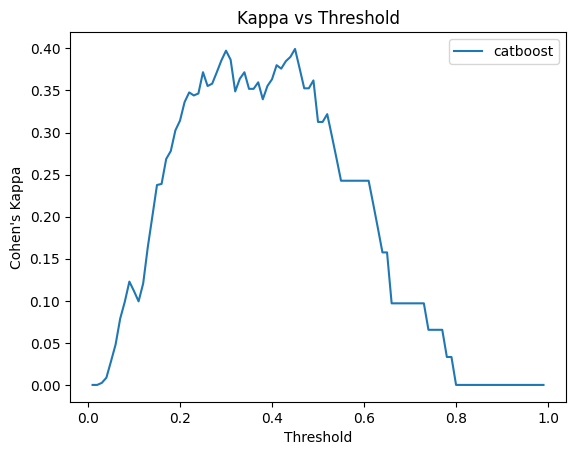

In [ ]:
analista_clasificacion_3.plot_cohens_kappa(["catboost"])

## 3.5 Experiment 5

Probando balanceos de parámetro

In [483]:
# redefine catboost for simpler first model.
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__iterations': [50,100,150],
            'classifier__auto_class_weights': ['Balanced']
        }
    )

imputer_catboost = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy="most_frequent"), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer_catboost)
])

#  Random stays equal but gets added 
models["random_forest"][1]["classifier__class_weight"] = ['balanced']

In [418]:
analista_clasificacion_5 = salm.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration5")

analista_clasificacion_5.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_target, 
                                        param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_5.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.999205,0.999206,0.999205,0.999204,0.997045,1.000000,1.000000,0.854006,0.164515,12.0
test,0.866667,0.856985,0.866667,0.833407,0.294776,0.750189,0.526869,0.854006,0.164515,12.0


In [494]:
# Transform data with full pipeline
X_preprocessed = preprocessing_pipeline_catboost.fit_transform(X)

for col in categorical:
    print(f"Column {col}: {set(X_preprocessed[col])}")


Column businesstravel: {'Travel_Rarely', 'Travel_Frequently', 'Non-Travel'}
Column department: {'Sales', 'Research & Development', 'Human Resources'}
Column education: {1, 2, 3, 4, 5}
Column educationfield: {'Technical Degree', 'Medical', 'Marketing', 'Life Sciences', 'Other'}
Column gender: {'Female', 'Male'}
Column joblevel: {1, 2, 3, 4, 5}
Column jobrole: {'Laboratory Technician', 'Research Director', 'Healthcare Representative', 'Manufacturing Director', 'Human Resources', 'Sales Representative', 'Sales Executive', 'Research Scientist', 'Manager'}
Column maritalstatus: {'Married', 'Divorced', 'Single'}
Column numcompaniesworked: {'9.0', '5.0', 'unknown', '2.0', '6.0', '8.0', '3.0', '7.0', '1.0', '4.0'}
Column percentsalaryhike: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, '23 or more', 22}
Column stockoptionlevel: {0, 1, 2, 3}
Column trainingtimeslastyear: {0, 1, 2, 3, 4, 5, 6}
Column yearssincelastpromotion: {0, 1, 2, 3, 4, 5, 6, 7, '8 or more'}
Column yearswithcurrmanager: {0, 1,

In [490]:
analista_clasificacion_5 = salm.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration5")

analista_clasificacion_5.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_5.calcular_metricas("catboost")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2613, in _catboost.get_cat_factor_bytes_representation
  File "_catboost.pyx", line 2128, in _catboost.get_id_object_bytes_string_representation
_catboost.CatBoostError: bad object for id: 4.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3100, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2620, in _catboost.get_cat_factor_bytes_representation
_catboost.CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=19]=4.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2613, in _catboost.get_cat_factor_bytes_representation
  File "_catboost.pyx", line 2128, in _catboost.get_id_object_bytes_string_representation
_catboost.CatBoostError: bad object for id: 3.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\catboost\core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3100, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2620, in _catboost.get_cat_factor_bytes_representation
_catboost.CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=19]=3.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.


## 3.5 Experiment 5

Integrar SMOTE-NC en el mejor algoritmo hasta el momento, RandomForest, para comprobar si mejora las métricas de AUC-PR.

In [ ]:
# Define the SMOTE-NC and Tomek Links steps
smote_nc = SMOTENC(categorical_features=categorical, random_state=seed, sampling_strategy=0.6)
tomek_links = TomekLinks(sampling_strategy='majority')

imputer = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

# Combine into a pipeline to later append the model
preprocessing_pipeline_target_SMOTE = Pipeline([
    ('imputer', imputer),
    ('smote_nc', smote_nc),
    ('tomek_links', tomek_links),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

Checking the preprocessing pipeline:

In [ ]:
preprocessing_pipeline_target_SMOTE.fit_transform(X,y).sample(7)

,age,distancefromhome,monthlyincome,totalworkingyears,yearsatcompany,businesstravel_Travel_Rarely,businesstravel_Travel_Frequently,businesstravel_Non-Travel,department_Sales,department_Research & Development,...,percentsalaryhike,trainingtimeslastyear,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating_3.0,performancerating_4.0
118,51.0,1.0,41050.0,18.0,7.0,1,0,0,0,1,...,0.175071,0.174873,0.192,0.133047,0.140594,0.110236,0.170868,0.154341,0,1
1256,30.0,1.0,20330.0,12.0,12.0,0,1,0,0,1,...,0.136364,0.172414,0.16947,0.133047,0.140594,0.110236,0.139202,0.211065,1,0
3085,41.0,7.0,27820.0,10.0,10.0,1,0,0,0,1,...,0.136364,0.174873,0.192,0.133047,0.148026,0.110236,0.139202,0.156962,1,0
690,30.0,6.0,30410.0,9.0,9.0,1,0,0,0,1,...,0.134529,0.174873,0.192,0.094832,0.148026,0.229236,0.139202,0.156962,1,0
717,55.0,19.0,46800.0,24.0,19.0,1,0,0,0,1,...,0.136364,0.181185,0.16947,0.094832,0.247492,0.166667,0.170868,0.174194,1,0
1083,31.0,2.0,103770.0,10.0,10.0,1,0,0,0,1,...,0.136364,0.174873,0.192,0.145604,0.148026,0.166667,0.139202,0.154341,1,0
1075,46.0,4.0,27430.0,14.0,8.0,1,0,0,0,1,...,0.180444,0.146722,0.192,0.133047,0.140594,0.165541,0.139202,0.174194,0,1


# 4. Selección de mejor threshold y calibración de modelo